In [6]:
#import
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import linregress

In [7]:
#import environmental data
test_look_times = [
    "2025-07-08 15:30:51",
    "2025-07-09 10:00:51",
    "2025-07-09 14:30:51",
    "2025-07-10 10:00:51",
    "2025-07-10 14:00:51",
    "2025-07-11 10:00:51",
    "2025-07-15 10:00:51",
    "2025-07-15 14:30:51",
    "2025-07-16 10:00:51",
    "2025-07-16 14:30:51"
]

# Read the environmental data
df = pd.read_excel("Meter-Plus-13_data.xls")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

results = []

for i, t in enumerate(test_look_times):
    t_start = pd.to_datetime(t)
    t_end = t_start + timedelta(hours=2)
    mask = (df['Timestamp'] >= t_start) & (df['Timestamp'] < t_end)
    sub_df = df.loc[mask]
    avg_humidity = sub_df['Relative_Humidity(%)'].mean()
    avg_temperature = sub_df['Temperature_Celsius(°C)'].mean()
    participant = f"{i+1:02d}_EB"
    results.append({
        'participant': participant,
        'avg humidity': avg_humidity,
        'avg temperature': avg_temperature
    })

# Save to Excel
results_df = pd.DataFrame(results)
results_df.to_excel("temperature_participant_summary.xlsx", index=False)


In [8]:
#import participant data

blink_rate_file = "blink_rate_by_participant.xlsx"
temperature_file = "temperature_participant_summary.xlsx"
mbi_file = "blink_MBI_analysis_summary.xlsx"

df_blink = pd.read_excel(blink_rate_file)
df_temp = pd.read_excel(temperature_file)
df_mbi = pd.read_excel(mbi_file)

#Compute avg MBI per participant with your rules

def extract_mbi_final(sub):
    """Apply the MBI selection rules to a participant's tasks."""
    mbis = []
    for _, row in sub.iterrows():
        eog_val = row.get("MBI Value (Longest Gap, s) EOG", np.nan)
        tobii_val = row.get("MBI Value (Longest Gap, s) Tobii", np.nan)
        mbi_val = row.get("MBI Value (Longest Gap, s)", np.nan)
        if not np.isnan(mbi_val):
            mbis.append(mbi_val)
    return np.nanmean(mbis) if len(mbis) > 0 else np.nan

# The participant column is typically in Task_ID as "01_EB_MBI_*"
df_mbi['Participant'] = df_mbi['Task_ID'].str.extract(r'(\d{2}_EB)')
avg_mbi = df_mbi.groupby('Participant')["MBI Value (Longest Gap, s)"].mean().reset_index()
avg_mbi = avg_mbi.rename(columns={"MBI Value (Longest Gap, s)": "avg MBI"})
df_blink['Participant'] = df_blink['Participant'].str.strip()
df_temp['participant'] = df_temp['participant'].str.strip()
avg_mbi['Participant'] = avg_mbi['Participant'].str.strip()

merged = pd.merge(df_blink, df_temp, left_on="Participant", right_on="participant")
merged = pd.merge(merged, avg_mbi, left_on="Participant", right_on="Participant")



In [9]:
#plot function
def plot_regression(x, y, x_label, y_label, title, filename):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, label="Data")
    plt.plot(x, slope * np.array(x) + intercept, color="red", label=f"Fit: $R^2$={r_value**2:.2f}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

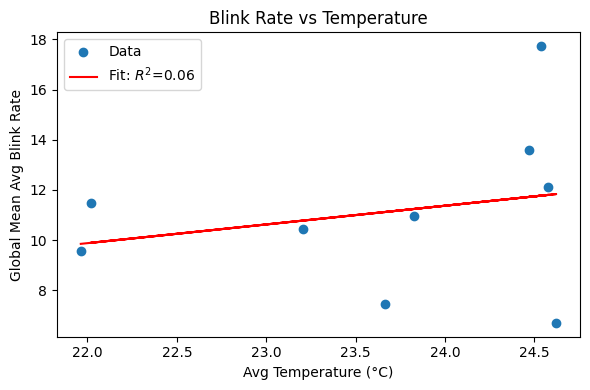

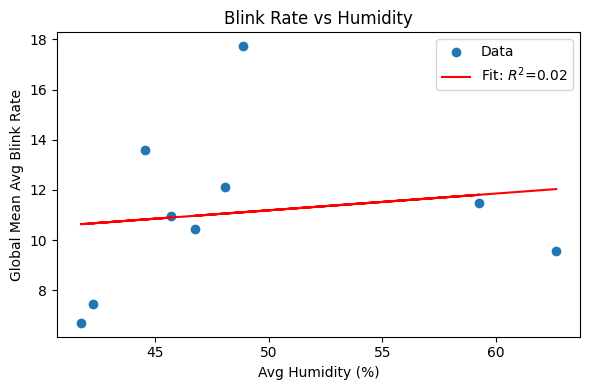

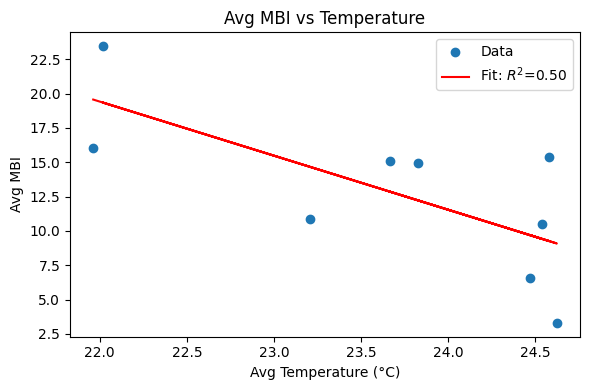

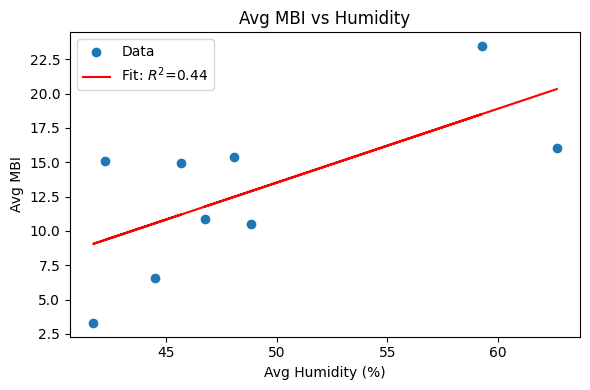

Full summary saved as 'full_blink_MBI_temperature_summary.xlsx'


In [10]:
#plot
plot_regression(
    merged['avg temperature'], merged['Global Mean Avg Blink Rate'],
    "Avg Temperature (°C)", "Global Mean Avg Blink Rate",
    "Blink Rate vs Temperature", "blinkrate_vs_temperature.png"
)

# Blink rate vs humidity
plot_regression(
    merged['avg humidity'], merged['Global Mean Avg Blink Rate'],
    "Avg Humidity (%)", "Global Mean Avg Blink Rate",
    "Blink Rate vs Humidity", "blinkrate_vs_humidity.png"
)

#MBI vs temp
plot_regression(
    merged['avg temperature'], merged['avg MBI'],
    "Avg Temperature (°C)", "Avg MBI",
    "Avg MBI vs Temperature", "mbi_vs_temperature.png"
)

#MBI vs humidity
plot_regression(
    merged['avg humidity'], merged['avg MBI'],
    "Avg Humidity (%)", "Avg MBI",
    "Avg MBI vs Humidity", "mbi_vs_humidity.png"
)

# Save merged summary
merged.to_excel("full_blink_MBI_temperature_summary.xlsx", index=False)
print("Full summary saved as 'full_blink_MBI_temperature_summary.xlsx'")